Выбор региона анализа

In [53]:
region = 'АЛМ'

Импорт библиотек

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
plt.style.use('seaborn')

C:\Users\killr\AppData\Local\Temp\ipykernel_13164\3352321590.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Загрузка данных

In [55]:
Sales = pd.read_excel('data\Загрузка продажи '+region+'.xlsx')
Stocks = pd.read_excel('data\Остатки загрузка '+region+'.xlsx')
Nomen = pd.read_excel('data\Загрузка справочник '+region+'.xlsx')

*Проверим дубликаты прямой и НВС и объединим их в один артикул*

In [56]:
multi_df = Nomen.groupby(['ТОВАР','ЕД ИЗМ','ПОСТАВЩИК'])['АРТИКУЛ'].unique().reset_index()
multi_df['len'] = multi_df['АРТИКУЛ'].apply(len)
art_groups = list(multi_df[multi_df['len']>1]['АРТИКУЛ'].values)

arts_to_delete = list()
d_art_head = dict()
for item in art_groups:
    for art in item:
        l = list(item.copy())
        l.pop(0)
        d_art_head[art] = [item[0], l]
        arts_to_delete.append(*l)

arts_to_delete = list(set(arts_to_delete))

Sales['АРТИКУЛ'] = Sales['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Stocks['АРТИКУЛ'] = Stocks['АРТИКУЛ'].apply(lambda x: x if x not in list(d_art_head.keys()) else d_art_head[x][0])
Nomen['ДУБЛИКАТЫ'] = Nomen['АРТИКУЛ'].apply(lambda x: '' if x not in list(d_art_head.keys()) else d_art_head[x][1])

Nomen.index = Nomen['АРТИКУЛ']
Nomen = Nomen.drop(arts_to_delete,axis=0).drop('АРТИКУЛ',axis=1)
Nomen = Nomen.reset_index()


*Сделаем преодразования даты и вычислим параметр медианных недельных продаж*

In [57]:
Sales['ДАТА'] = Sales['ДАТА'].apply(lambda x: x[:-3])
Sales['ДАТА'] = pd.to_datetime(Sales['ДАТА'], format='%d.%m.%Y')

In [58]:
Sales['НЕДЕЛЯ'] = Sales['ДАТА'].dt.dayofyear // 7

week_sales = pd.pivot_table(data = Sales, columns='АРТИКУЛ',index='НЕДЕЛЯ', values='ПРОДАЖА ШТ', aggfunc='sum')
week_sales = week_sales.fillna(0)
week_sales = week_sales.median()

In [59]:
Stocks['ДАТА'] = pd.to_datetime(Stocks['ДАТА'] , format='%d.%m.%Y')

Создадим таблицу по параметрам артикулов и добавим в нее параметры, связанные с клиентами и статистикой продаж

In [60]:
Nomen['ПОСТАВЩИК'] = Nomen['ПОСТАВЩИК'].apply(lambda x: x[:15])
Nomen['АГ'] = Nomen['АГ'].apply(lambda x: str(x)[:20])

*Число клиентов*

In [61]:
table = Sales.groupby('АРТИКУЛ')['КЛИЕНТ'].nunique()

In [62]:
Client_count = list(Nomen['АРТИКУЛ'].unique())
Client_count = pd.DataFrame(Client_count, columns=['АРТИКУЛ'])
Client_count['Count'] = Client_count['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table[x])
Client_count.index = Client_count['АРТИКУЛ']
Client_count = Client_count.drop('АРТИКУЛ', axis=1)

In [63]:
piv_nom = Nomen.copy()
piv_nom['КЛИЕНТОВ'] = piv_nom['АРТИКУЛ'].apply(lambda x: Client_count.loc[x])

In [64]:
piv_nom['week_sales_median'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(week_sales.index) else week_sales.loc[x])

*Доля самого крупного клиента*

In [65]:
table = Sales.groupby(['АРТИКУЛ', 'КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by=['АРТИКУЛ','ПРОДАЖА ШТ'], ascending=False)
table2 = Sales.groupby(['АРТИКУЛ'])['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).reset_index()
table = pd.merge(left=table, right=table2, on='АРТИКУЛ', how='left')
table['ДОЛЯ'] = table['ПРОДАЖА ШТ_x'] / table['ПРОДАЖА ШТ_y']
table = table.groupby('АРТИКУЛ')['ДОЛЯ'].max()
piv_nom['ДОЛЯ МАКС КЛИЕНТА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ЕД ИЗМ,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,ДУБЛИКАТЫ,КЛИЕНТОВ,week_sales_median,ДОЛЯ МАКС КЛИЕНТА
0,100024,"Коробка для пиццы 300х300х40 мм, бел., микрого...",шт,Нет,КТК ООО,Да,Коробки для пиццы,Коробки для пиццы белые из микрогофрокартона 3...,,4,0.0,0.8
1,100027,"Коробка для пиццы 300х300х40 мм, крафт, микрог...",шт,Нет,КТК ООО,Да,Коробки для пиццы,Коробки для пиццы крафт из микрогофрокартона,,0,0.0,0.0


*Загрузка средней цены за период*

In [66]:
table = Stocks.groupby('АРТИКУЛ')['ЦЕНА'].median()
piv_nom['ЦЕНА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])

*Вычисление стат параметров стока и продаж*

In [67]:
table = pd.pivot_table(Stocks,values='ОСТАТОК',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
stock_nulls = table.isnull().mean()
table = table.fillna(0)



In [68]:
piv_nom = pd.merge(left=piv_nom, right=table.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'stocks_mean','std':'stocks_std', 'max':'stocks_max','50%':'stocks_median'}, axis=1)

In [69]:
curr_stock = table.iloc[-1:].T
piv_nom['curr_stock'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(curr_stock.index) else curr_stock.loc[x].values[0]) 

In [70]:
table2 = pd.pivot_table(Sales,values='ПРОДАЖА ШТ',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
sales_nulls = table2.isnull().mean()
table2 = table2.fillna(0)



In [71]:
piv_nom = pd.merge(left=piv_nom, right=table2.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'sales_mean','std':'sales_std', 'max':'sales_max','50%':'sales_median'}, axis=1)

In [72]:
piv_nom = piv_nom.fillna(0)

*Добавим признаки % дней без продаж и без остатков*

In [73]:
piv_nom['sales_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(sales_nulls.index) else sales_nulls[x])
piv_nom['stock_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(stock_nulls.index) else stock_nulls[x])

*Добавим признак симметрии. Рассчитаем его как ковариацию вектора последовательных продаж с вектором линейного роста от минимума к максимуму*

In [74]:
def calc_sym_coef(art, table):
    min_val = table[art].min()
    max_val = table[art].max()
    v = np.linspace(min_val,max_val,table.shape[0])
    w = table[art].values
    v = v - v.mean()
    v = v / np.linalg.norm(v)
    w = w - w.mean()
    if np.linalg.norm(w)<0.0001:
        return 0
    w = w /np.linalg.norm(w)
    return v@w

In [75]:
piv_nom['stock_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.columns) else calc_sym_coef(x,table))
piv_nom['sales_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table2.columns) else calc_sym_coef(x,table2))

*Создадим признаки в деньгах*

In [76]:
stat_features_units = ['stocks_mean','stocks_std','stocks_max','stocks_median',
                    'sales_mean', 'sales_std', 'sales_max','sales_median','curr_stock','week_sales_median']

for feature in stat_features_units:
    piv_nom[feature+'_$'] = piv_nom[feature] * piv_nom['ЦЕНА']

*Посмотрим на распределения созданных признаков и решим, что их этого логарифмировать*

In [77]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА','week_sales_median_$']
#
#fig, axes = plt.subplots(len(features)//2+1,2, figsize = [10,15])
#for i,feature in enumerate(features):
#    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
#    axes[i//2][i%2].set_ylabel(feature)

In [78]:
features_to_log = ['stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ','week_sales_median_$']

for feature in features_to_log:
    piv_nom[feature+'_log'] = piv_nom[feature].apply(lambda x: np.log(x+1))

In [79]:
features = ['stocks_mean_$_log', 'stocks_std_$_log', 'stocks_max_$_log',
       'stocks_median_$_log', 'sales_mean_$_log', 'sales_std_$_log',
       'sales_max_$_log', 'sales_median_$_log', 'КЛИЕНТОВ_log','week_sales_median_$_log']

#fig, axes = plt.subplots(len(features)//2+1,2, figsize = [10,10])
#for i,feature in enumerate(features):
#    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
#    axes[i//2][i%2].set_ylabel(feature)

***Отбор признаков для кластеризации***

In [80]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'stocks_max_$_log', 'sales_mean_$_log','sales_median_$_log', 'КЛИЕНТОВ_log','week_sales_median_$_log']

clust_data = piv_nom[features]

#sns.heatmap(clust_data.corr(), annot=True, fmt='.2f')

In [81]:
#clust_data.isnull().sum()

*Нормализуем данные*

In [82]:

scaler = MinMaxScaler()
clust_data = scaler.fit_transform(clust_data)

*Попробуем кластеризировать данные*

In [83]:
from sklearn.cluster import AgglomerativeClustering

params = list()
for i in range(3,10):
    agc = AgglomerativeClustering(n_clusters=i)
    clusters = agc.fit_predict(clust_data)
    params.append([i,silhouette_score(clust_data,clusters)])
    
params = pd.DataFrame(params, columns=['K','silhouette'])
params.sort_values('silhouette', ascending=False)

,K,silhouette
5,8,0.366305
6,9,0.364098
4,7,0.346166
3,6,0.325503
2,5,0.303534
1,4,0.268601
0,3,0.243141


In [84]:
agc = AgglomerativeClustering(n_clusters=9)
agc.fit(clust_data)
#display(pd.Series(agc.labels_).value_counts().sort_values(ascending=False)/pd.Series(agc.labels_).value_counts().sum()*100)

agc_df = pd.DataFrame(clust_data, columns=features)
agc_df['cluster'] = agc.labels_
piv_nom['cluster'] = agc.labels_
#agc_df = agc_df[(agc_df['cluster'] != 0) & (agc_df['cluster'] != 6)& (agc_df['cluster'] != 2)
#                & (agc_df['cluster'] != 5)& (agc_df['cluster'] != 8)& (agc_df['cluster'] != 7)& (agc_df['cluster'] != 4)]
#sns.heatmap(agc_df.groupby('cluster').mean(), annot=True, fmt='.3f', cmap='Reds')


После анализа результатов было создано решающее правило, которое помогло универсально подойти у 2м филиалам (ну и к любоиу количеству складов в будующем). Вся суть ML здесь в том, что оно помогло подобрать "хорошие" правила для категоризации товаров.
Также пришлось признак недельной медианы для верного определения регулярных товаров

*Присвоение имен кластеров*

In [85]:
def set_cluster_name(art):
    df = scaler.transform(piv_nom[piv_nom['АРТИКУЛ'] == art][features])
    df = pd.DataFrame(df, columns=features)
    if df['sales_median_$_log'].iloc[0] > 0:
        return 'Ядерные'
    elif df['week_sales_median_$_log'].iloc[0] > 0:
        return 'Регулярные'
    elif (df['sales_mean_$_log'].iloc[0] == 0) & (df['stock_nulls'].iloc[0] == 0):
        return 'Висяки'
    elif (df['sales_mean_$_log'].iloc[0] == 0) & (df['КЛИЕНТОВ_log'].iloc[0] == 0) & (df['stock_sym'].iloc[0] < 0.33):
        return 'Висяки'
    elif (df['sales_mean_$_log'].iloc[0] == 0) & (df['КЛИЕНТОВ_log'].iloc[0] == 0) & (df['stock_sym'].iloc[0] > 0.66):
        return 'Плохие новинки'
    elif (df['stock_nulls'].iloc[0] < 0.35):
        return 'Опасные'
    elif (df['stock_sym'].iloc[0] > 0.57):
        return 'Хорошие новинки'
    else:
        return 'Под заказ'

piv_nom['cluster_name'] = piv_nom['АРТИКУЛ'].apply(set_cluster_name)


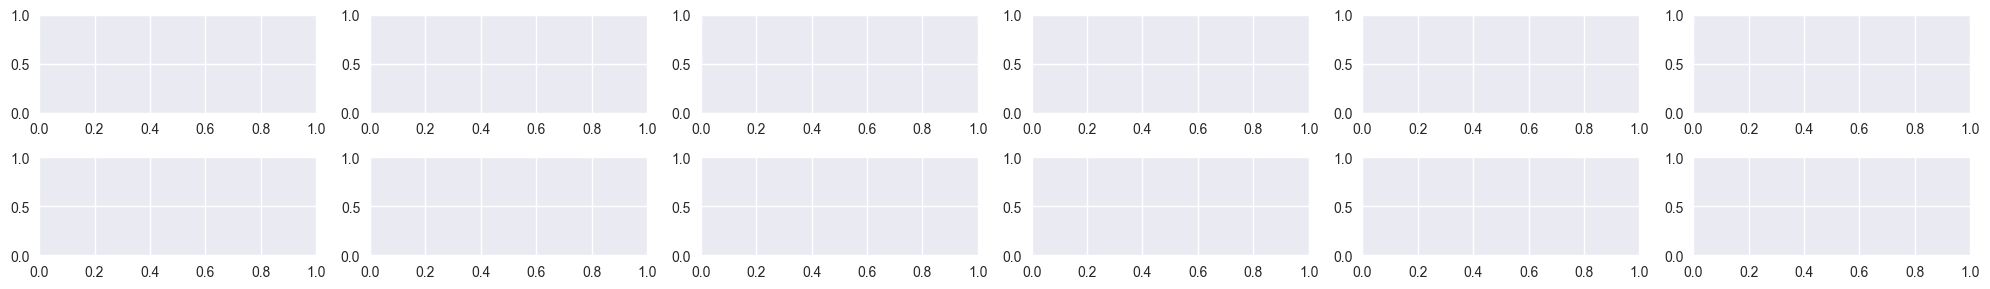

In [86]:

cluster = list(piv_nom[piv_nom['cluster_name']==' ']['АРТИКУЛ'])
#cluster = list(piv_nom[piv_nom['sales_median_$_log'] > 0]['АРТИКУЛ'])

fig, axes = plt.subplots(len(cluster)//6+2,6, figsize = [20,len(cluster)//6*2+3])
for i,art in enumerate(cluster):
    if art in list(table.columns):
        sns.lineplot(table[art].T, ax=axes[i//6][i%6])
    if art in list(table2.columns):    
        sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
    axes[i//6][i%6].set_xlabel(' ')
    axes[i//6][i%6].set_ylabel(' ')
    axes[i//6][i%6].set_title(art)
     
plt.tight_layout()

Вычисление дефицитов. Считаем их только для кластеров: Регулярный, Ядерный, Хорошие новинки, Опасные

*Вычистление границы уровня дефицита*

In [87]:
piv_nom['deficit_level'] = piv_nom['sales_mean']+3*piv_nom['sales_std'] #Это Эвристика конечно
#piv_nom['deficit_level'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if piv_nom[piv_nom['АРТИКУЛ']==x]['cluster_name'].iloc[0] == 'Под заказ' else x)
piv_nom['curr_deficit'] = piv_nom['deficit_level'] - piv_nom['curr_stock']
piv_nom['curr_deficit'] = piv_nom['curr_deficit'].apply(lambda x: x if x>0 else 0)
piv_nom['curr_deficit_$'] = piv_nom['curr_deficit']*piv_nom['ЦЕНА']

*Вычисление неликвидов*

In [88]:
piv_nom['overstock_level'] = piv_nom['sales_mean']*43+3*piv_nom['sales_std']
piv_nom['curr_overstok'] = piv_nom['curr_stock'] - piv_nom['overstock_level']
piv_nom['curr_overstok'] = piv_nom['curr_overstok'].apply(lambda x: x if x>0 else 0)
piv_nom['curr_overstok_$'] = piv_nom['curr_overstok']*piv_nom['ЦЕНА']

*Формирование зон стока: дефицит, риск дефицита, оптимум, излишек, неликвид*

In [89]:
piv_nom['risk_zone_level'] = piv_nom['deficit_level'] + (piv_nom['overstock_level'] - piv_nom['deficit_level'])*(1/3)
piv_nom['optimum_zone_level'] = piv_nom['deficit_level'] + (piv_nom['overstock_level'] - piv_nom['deficit_level'])*(2/3)
piv_nom['risk_zone_level_$'] = piv_nom['risk_zone_level']*piv_nom['ЦЕНА']
piv_nom['optimum_zone_level_$'] = piv_nom['optimum_zone_level']*piv_nom['ЦЕНА']

In [90]:
def set_stock_zone(art):
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    deficit_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['deficit_level'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    optimum_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['optimum_zone_level'].iloc[0]
    overstock_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['overstock_level'].iloc[0]
    
    if curr_stock > overstock_level:
        return 'Неликвид'
    elif curr_stock > optimum_zone_level:
        return 'Излишек'
    elif curr_stock > risk_zone_level:
        return 'Оптимум'
    elif curr_stock > deficit_level:
        return 'Риск дефицита'
    else:
        if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] == 'Под заказ':
            return 'Под заказ без остатка'
        else:    
            return 'Дефицит'
        
piv_nom['stock_zone'] = piv_nom['АРТИКУЛ'].apply(set_stock_zone)

Расчет общих показателей

In [91]:
#Число товаров по кластерам
cluster_artnum = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()
#Число товаров по типам стока
stockzone_artnum = piv_nom.groupby('stock_zone')['АРТИКУЛ'].nunique()
#Общая оборачиваемость
table4 = Stocks.copy()
table4['ОСТАТОК_$'] = table4['ОСТАТОК']* table4['ЦЕНА']
mean_stock = table4.groupby('ДАТА')['ОСТАТОК_$'].sum().mean()
mean_sales = piv_nom['sales_mean_$'].sum()
turnover = mean_stock/mean_sales*7/5
#Клиентов на артикул
mean_clints_by_art = piv_nom.groupby('АРТИКУЛ')['КЛИЕНТОВ'].sum().mean()
#Сумма дефицита по Регулярному, Ядерному, Хорошим новинкам
deficit_sum = 0
for feature in ['Ядерные', 'Регулярные','Хорошие новинки']:
    deficit_sum += piv_nom[piv_nom['cluster_name'] == feature]['curr_deficit_$'].sum()
#Сумма неликвида по Висякам, Опасным, Плохим новинкам, Под заказ
overstock_sum = 0
for feature in ['Висяки', 'Плохие новинки','Под заказ', 'Опасные']:
    overstock_sum += piv_nom[piv_nom['cluster_name'] == feature]['curr_overstok_$'].sum()    

#Индекс эффективности товарного запаса
stocks_eff_index = (stockzone_artnum.loc['Оптимум'] + stockzone_artnum.loc['Излишек'] + stockzone_artnum.loc['Риск дефицита'])/(stockzone_artnum.sum()-stockzone_artnum.loc['Под заказ без остатка'])*100
#Индекс эффективности ассортиментной матрицы
v = np.linspace(0,1,7)
v = v - v.mean()
v = v/np.linalg.norm(v)
w = np.array([cluster_artnum.loc['Висяки'],cluster_artnum.loc['Плохие новинки'],cluster_artnum.loc['Опасные'],cluster_artnum.loc['Под заказ'],cluster_artnum.loc['Хорошие новинки'],cluster_artnum.loc['Регулярные'],cluster_artnum.loc['Ядерные']]).astype('float')
w = w - w.mean()
w = w/np.linalg.norm(w)
atrmatrix_eff_index = (v@w /2 + 1/2)*100
#
params = pd.DataFrame([turnover, deficit_sum/1000000, overstock_sum/1000000, mean_clints_by_art,stocks_eff_index,atrmatrix_eff_index], index=['Оборачиваемость кд','Дефицит млн тенге','Неликвид млн тенге','Клиентов на артикул','Эффективность запасов','Эффективность ассортимента'])

In [92]:
table4 = pd.read_excel('Динамика '+str(region)+'.xlsx', index_col=0)
if str(table4.index.max()) !=  str(Stocks['ДАТА'].dt.date.max()):
    table5 = pd.concat([cluster_artnum, stockzone_artnum, params], axis=0).rename({0:str(Stocks['ДАТА'].dt.date.max())},axis=1).T
    table4 = pd.concat([table4, table5], axis=0)

table4.to_excel('Динамика '+str(region)+'.xlsx')


Расчет выгрузок в Эксель

In [93]:
#Хорошие группы в дефиците
table5 = piv_nom[(piv_nom['cluster_name'] == 'Ядерные') | 
        (piv_nom['cluster_name'] == 'Регулярные') | 
        (piv_nom['cluster_name'] == 'Хорошие новинки')]
table5 = table5[table5['curr_deficit_$'] > 0].sort_values(by='curr_deficit_$', ascending=False)
table5 = table5[['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name', 'curr_deficit', 'curr_deficit_$',
       'stock_zone']]
table5.to_excel('output\Дефициты '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')

#Плохие группы в неликвиде ['Висяки', 'Плохие новинки','Под заказ', 'Опасные']
table5 = piv_nom[(piv_nom['cluster_name'] == 'Висяки') | 
        (piv_nom['cluster_name'] == 'Плохие новинки') | 
        (piv_nom['cluster_name'] == 'Под заказ') |
        (piv_nom['cluster_name'] == 'Опасные')]
table5 = table5[table5['curr_overstok_$'] > 0].sort_values(by='curr_overstok_$', ascending=False)
table5 = table5[['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name', 'curr_overstok', 'curr_overstok_$',
       'stock_zone']]
table5.to_excel('output\Неликвиды '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')

#Ядерные
piv_nom[piv_nom['cluster_name'] == 'Ядерные'][['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name']].to_excel('output\Ядерные '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')

#Без движения
piv_nom[(piv_nom['cluster_name'] == 'Висяки') & (piv_nom['curr_overstok_$']>0)][['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'cluster_name','curr_overstok_$','curr_overstok']].to_excel('output\Висяки '+str(region)+' '+ str(Stocks['ДАТА'].dt.date.max()) +'.xlsx')


Визуализация результатов итогового отчета

C:\Users\killr\AppData\Local\Temp\ipykernel_13164\860425764.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


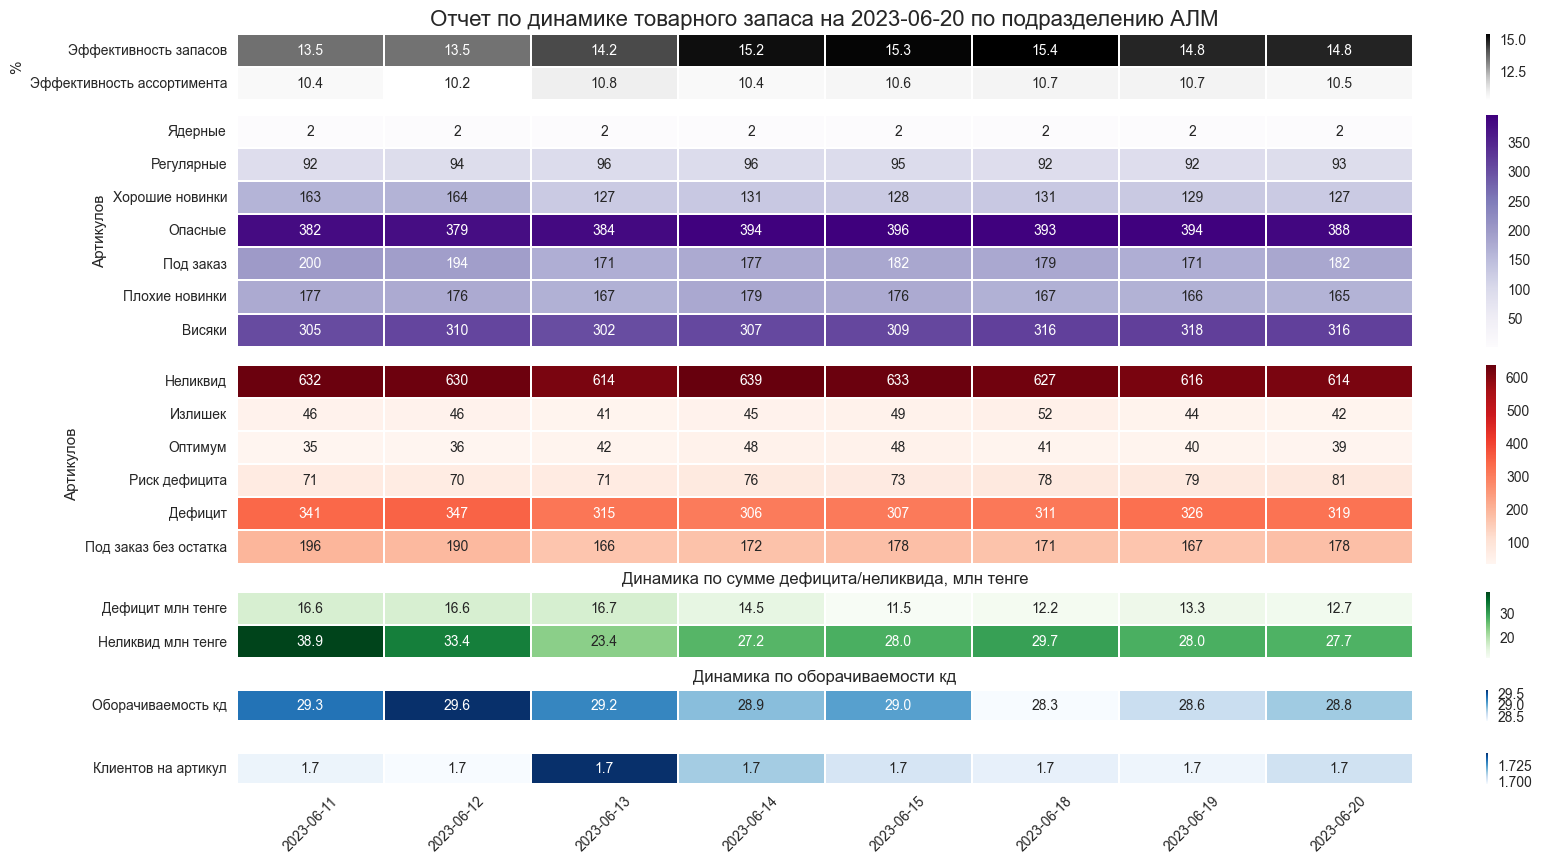

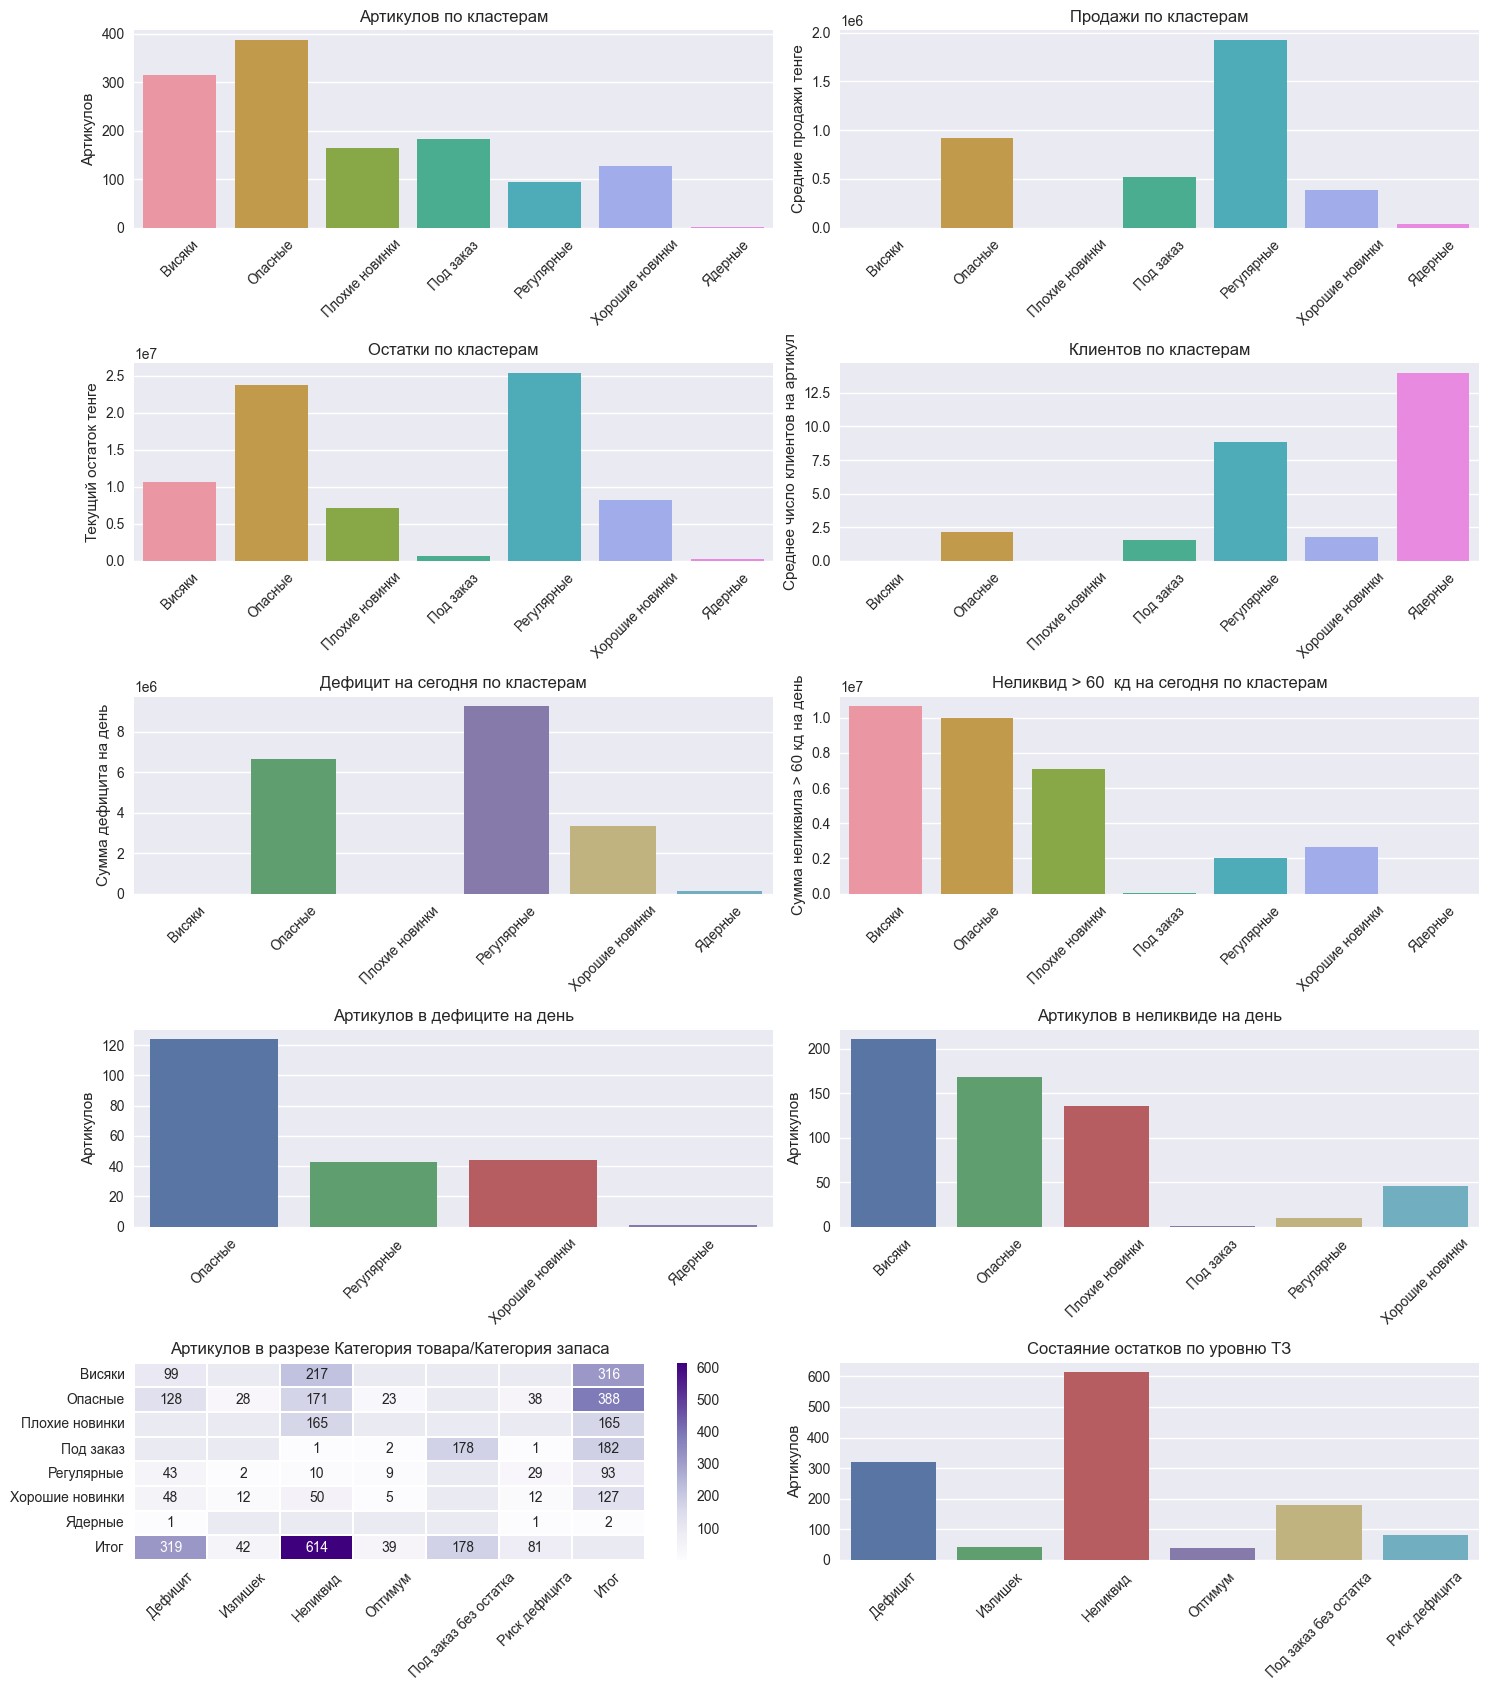

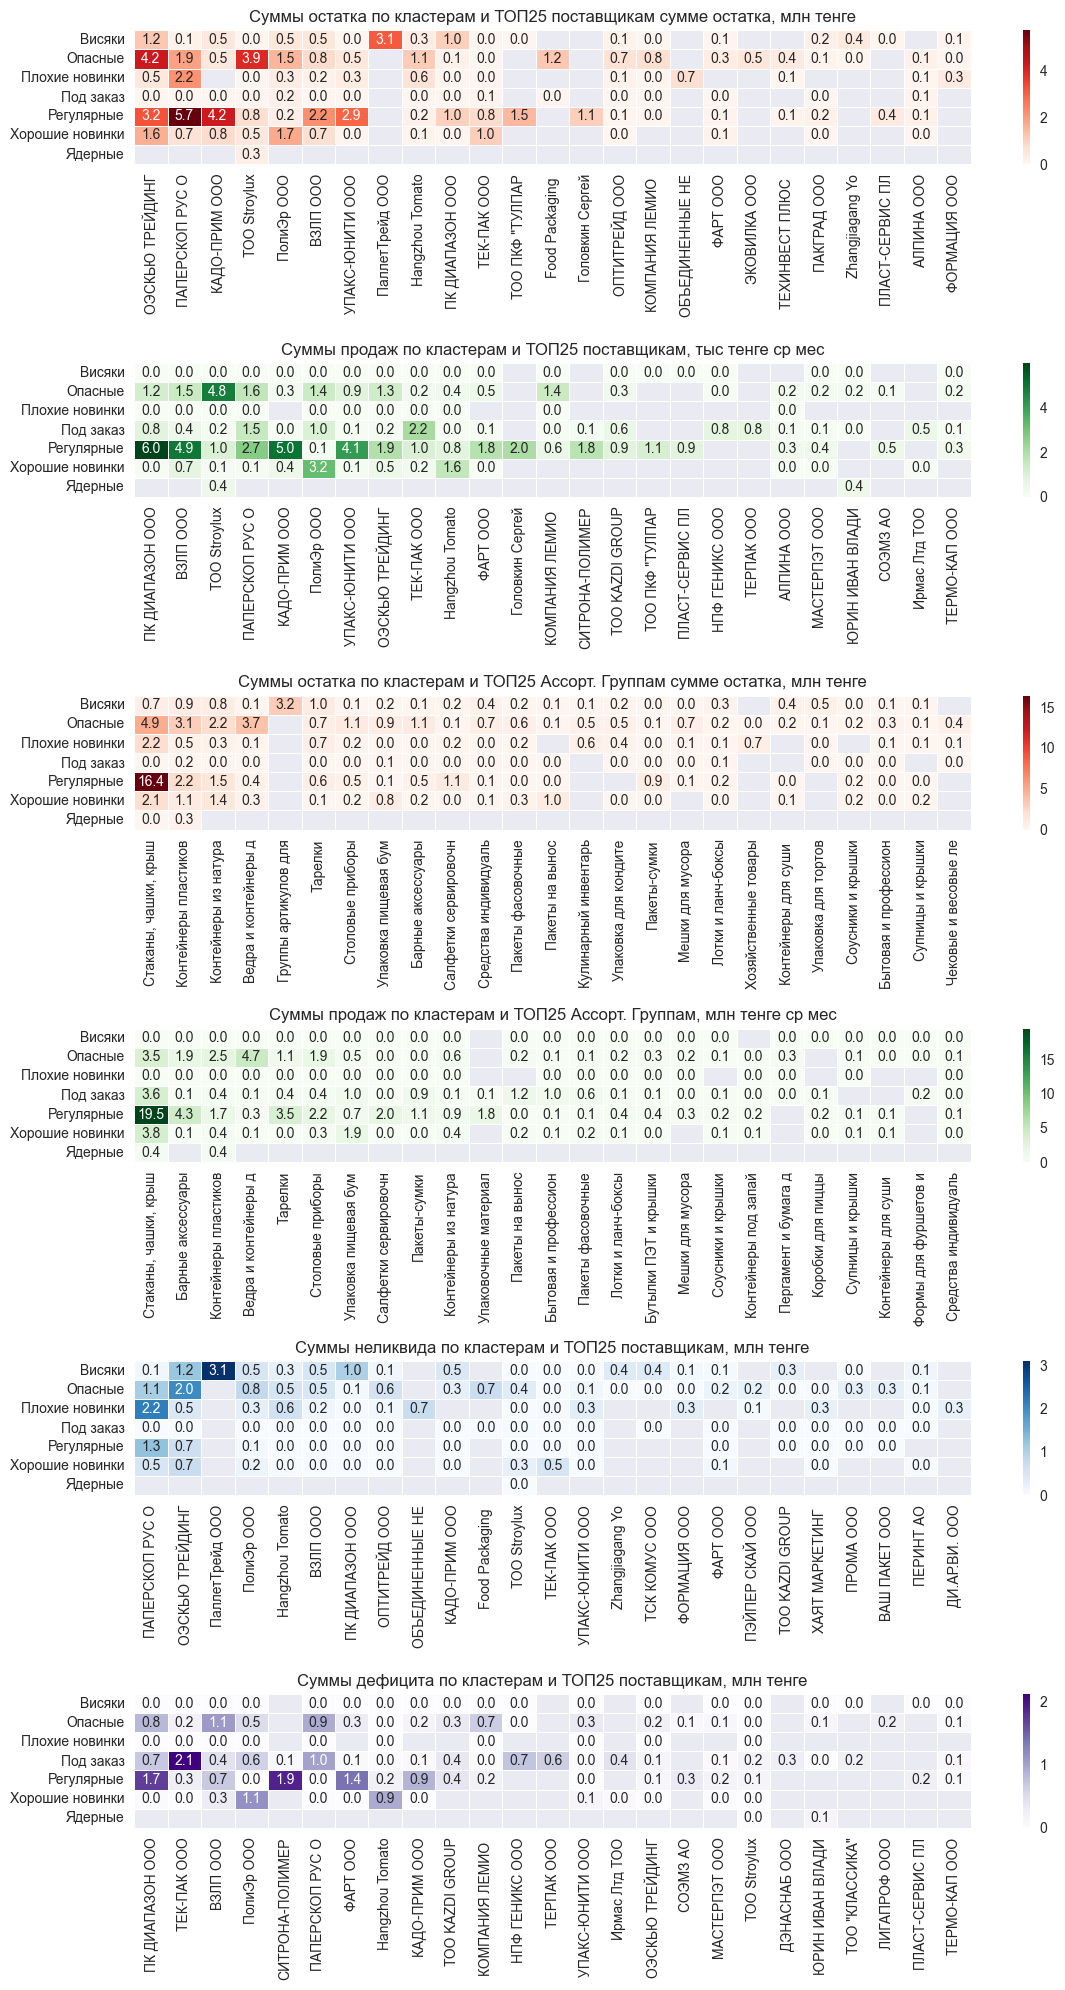

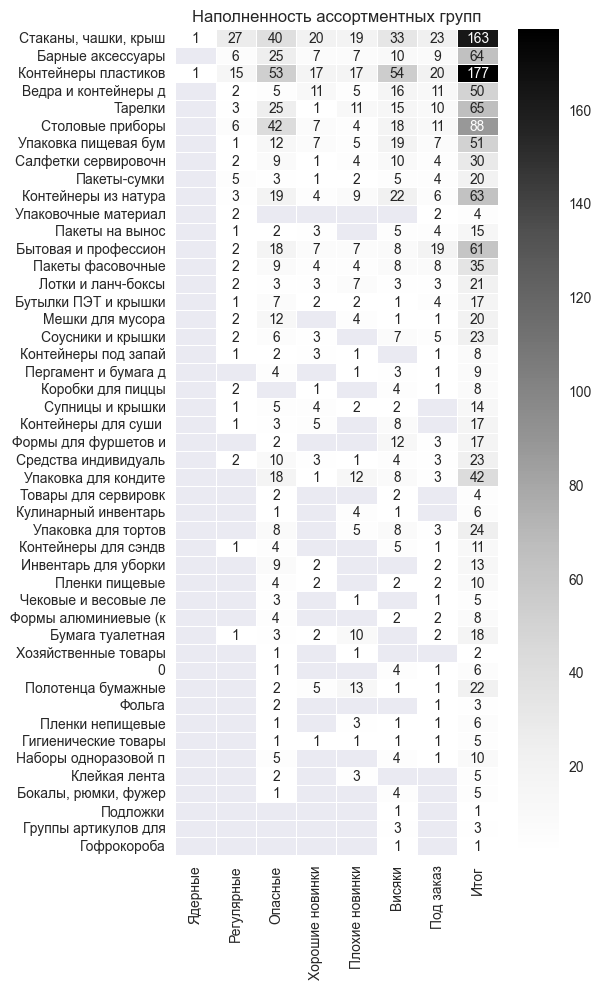

In [94]:

#Визуализация таблицы общих показателей в динамике
fig = plt.figure(figsize=[15,9])
ax0 = fig.add_axes([0.12,   0.86,  0.98, 0.105*0.7])
ax1 = fig.add_axes([0.12,   0.586,  0.98, 0.368*0.7])
ax2 = fig.add_axes([0.12, 0.345, 0.98, 0.316*0.7])
ax3 = fig.add_axes([0.12, 0.24, 0.98, 0.105*0.7])
ax4 = fig.add_axes([0.12, 0.17, 0.98, 0.05*0.7])
ax5 = fig.add_axes([0.12, 0.1, 0.98, 0.05*0.7])

if table4.shape[0] > 25:
    table4 = table4.iloc[:-25,:]

cat_list = ['Эффективность запасов','Эффективность ассортимента']
heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Greys', linewidths=0.1, ax=ax0) 
heat.set_title('Отчет по динамике товарного запаса на ' +str(Stocks['ДАТА'].dt.date.max()) + ' по подразделению '+str(region),fontdict={'size': 16})
heat.axes.set_ylabel('%')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Ядерные','Регулярные','Хорошие новинки','Опасные','Под заказ','Плохие новинки','Висяки']
heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.0f', cmap='Purples', linewidths=0.1, ax=ax1) 
#heat.set_title('Отчет по динамике товарного запаса на ' +str(Stocks['ДАТА'].dt.date.max()) + ' по подразделению '+str(region),fontdict={'size': 16})
heat.axes.set_ylabel('Артикулов')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')


cat_list = ['Неликвид','Излишек','Оптимум','Риск дефицита','Дефицит','Под заказ без остатка']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.0f', cmap='Reds', linewidths=0.1, ax=ax2) 
#heat.set_title('Динамика по типам остатка')
heat.axes.set_ylabel('Артикулов')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Дефицит млн тенге','Неликвид млн тенге']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Greens', linewidths=0.1, ax=ax3) 
heat.set_title('Динамика по сумме дефицита/неликвида, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.xaxis.set_ticklabels('')

cat_list = ['Оборачиваемость кд']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Blues', linewidths=0.1, ax=ax4) 
heat.set_title('Динамика по оборачиваемости кд')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.yaxis.set_tick_params(rotation=0)
heat.xaxis.set_ticklabels('')

cat_list = ['Клиентов на артикул']

heat = sns.heatmap(table4[cat_list].T, annot=True, fmt='.1f', cmap='Blues', linewidths=0.1, ax=ax5) 
#heat.set_title('Число клиентов на артикул')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.yaxis.set_tick_params(rotation=0)
heat.xaxis.set_tick_params(rotation=45)


plt.tight_layout()
fig.savefig('output\Динамика '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')
#Барплоты текущей ситуации по категориям

fig, axes = plt.subplots(5,2,figsize=[15,17])

table3 = piv_nom.groupby('cluster_name')['sales_mean_$'].sum()
bar1 = sns.barplot( x=table3.index, y=table3.values, ax=axes[0][1])
bar1.axes.set_ylabel('Средние продажи тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Продажи по кластерам')


table3 = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[0][0])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_stock_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][0])
bar1.axes.set_ylabel('Текущий остаток тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Остатки по кластерам')

table3 = piv_nom.groupby('cluster_name')['КЛИЕНТОВ'].mean()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][1])
bar1.axes.set_ylabel('Среднее число клиентов на артикул')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Клиентов по кластерам')

table3 = piv_nom[piv_nom['cluster_name']!='Под заказ'].groupby('cluster_name')['curr_deficit_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[2][0])
bar1.axes.set_ylabel('Сумма дефицита на день')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Дефицит на сегодня по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_overstok_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[2][1])
bar1.axes.set_ylabel('Сумма неликвила > 60 кд на день')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Неликвид > 60  кд на сегодня по кластерам')

table3 = piv_nom[(piv_nom['curr_deficit_$'] > 0) & (piv_nom['cluster_name'] != 'Под заказ')].groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[3][0])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов в дефиците на день')

table3 = piv_nom[piv_nom['curr_overstok_$'] > 0].groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[3][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов в неликвиде на день')


table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='stock_zone', values='АРТИКУЛ', aggfunc='nunique')
row_sum = table3.sum()
table3 = table3.T
col_sum = table3.sum()
table3 = pd.concat([table3, row_sum], axis=1)

table3 = table3.T
table3 = pd.concat([table3, col_sum], axis=1)
table3 = table3.rename({0:'Итог'}, axis=1)
table3 = table3.rename({0:'Итог'}, axis=0)
table3
heat = sns.heatmap(table3, annot=True, fmt='.0f', cmap='Purples', linewidths=0.1, ax=axes[4][0]) 
heat.set_title('Артикулов в разрезе Категория товара/Категория запаса')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
heat.xaxis.set_tick_params(rotation=45)


table3 = table3.drop('Итог', axis=1).drop('Итог', axis=0).sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[4][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Состаяние остатков по уровню ТЗ')

#Тепловые карты поставщик/АГ
plt.tight_layout()
fig.savefig('output\Параметры по категориям '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

fig, axes = plt.subplots(6,1,figsize=[12,20])

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_stock_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_stock_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Reds',linewidth=.5, annot=True, fmt='.1f', ax=axes[0])
heat.set_title('Суммы остатка по кластерам и ТОП25 поставщикам сумме остатка, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['sales_mean_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='sales_mean_$', aggfunc='sum')
table3 = table3 /1000000 * 21

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Greens',linewidth=.5, annot=True, fmt='.1f', ax=axes[1])
heat.set_title('Суммы продаж по кластерам и ТОП25 поставщикам, тыс тенге ср мес')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')


max_stock_suppliers = piv_nom.groupby('АГ')['curr_stock_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='АГ', values='curr_stock_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Reds',linewidth=.5, annot=True, fmt='.1f', ax=axes[2])
heat.set_title('Суммы остатка по кластерам и ТОП25 Ассорт. Группам сумме остатка, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('АГ')['sales_mean_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='АГ', values='sales_mean_$', aggfunc='sum')
table3 = table3 /1000000 * 21

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Greens',linewidth=.5, annot=True, fmt='.1f', ax=axes[3])
heat.set_title('Суммы продаж по кластерам и ТОП25 Ассорт. Группам, млн тенге ср мес')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_overstok_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_overstok_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Blues',linewidth=.5, annot=True, fmt='.1f', ax=axes[4])
heat.set_title('Суммы неликвида по кластерам и ТОП25 поставщикам, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_deficit_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_deficit_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap="Purples",linewidth=.5, annot=True, fmt='.1f', ax=axes[5])
heat.set_title('Суммы дефицита по кластерам и ТОП25 поставщикам, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')


plt.tight_layout()
fig.savefig('output\Аналитика поставщик-АГ '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')

#Наполненность ассортиментной матрицы
table3 = pd.pivot_table(data=piv_nom, index='АГ', columns='cluster_name', values='АРТИКУЛ', aggfunc='nunique')
max_stock_suppliers = piv_nom.groupby('АГ')['sales_mean_$'].sum().sort_values(ascending=False)
fig, axes = plt.subplots(1,1,figsize=[6,10])
table3 = table3.T[list(max_stock_suppliers.index)]
SUM_1 = table3.sum()
table3 = table3.T
table3['Итог'] = SUM_1
heat = sns.heatmap(table3[['Ядерные','Регулярные','Опасные','Хорошие новинки','Плохие новинки','Висяки','Под заказ','Итог']],  cmap="Greys",linewidth=.5, annot=True, fmt='.0f', ax=axes)
heat.set_title('Наполненность ассортментных групп')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

plt.tight_layout()
fig.savefig('output\Наполненность ассортментных групп '+str(region)+' '+str(Stocks['ДАТА'].dt.date.max())+'.png')



Расчет заказа

In [95]:
def count_orders(art):
    #Тут надо собирать данные из таблицы поставщик/прямая поставка
    regularity_days = 10
    transport_days = 8
    
    #Тут нужно собрать данные по клиентам и менеджерам

    
    #Расчитаем параметры
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    mean_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_mean'].iloc[0]
    stock_on_income = max([curr_stock - mean_level*transport_days,0])
    aim_stock = risk_zone_level + mean_level*regularity_days
    order = aim_stock - stock_on_income
    part_of_max_client = piv_nom[piv_nom['АРТИКУЛ'] == art]['ДОЛЯ МАКС КЛИЕНТА'].iloc[0]
    
    #Расчитаем заказ в зависимости от группы
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Ядерные','Регулярные','Хорошие новинки']:
        max_client = ''
        max_manager = ''
        if part_of_max_client > 0.8:
            max_client = Sales[Sales['АРТИКУЛ'] == art].groupby('КЛИЕНТ')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index[0]
            max_manager = Sales[Sales['КЛИЕНТ'] == max_client]['МЕНЕДЖЕР'].iloc[0]
            max_manager = ' менеджера '+ str(max_manager)
            
            max_client = ' если сохраняются заказы клиента ' + str(max_client) + max_manager
            
        
        return max([order,0]), 'Верить автозаказу' + max_client
    
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] == 'Опасные':
        
        d = dict()
        man_list = list(Sales[Sales['АРТИКУЛ'] == art].groupby('МЕНЕДЖЕР')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index)
        for man in man_list:
            dff = Sales[Sales['АРТИКУЛ'] == art].groupby(['МЕНЕДЖЕР','КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by='ПРОДАЖА ШТ',ascending=False)
            dff = dff[dff['МЕНЕДЖЕР']== man]['КЛИЕНТ'].unique()
            d[man] = list(dff)
        
        return max([risk_zone_level - stock_on_income,0]), 'Опасная позиция, проверить!: ' + str(d)
    if piv_nom[piv_nom['АРТИКУЛ'] == art]['cluster_name'].iloc[0] in ['Висяки','Плохие новинки']:
        return 0, '---'
    else:
        
        d = dict()
        man_list = list(Sales[Sales['АРТИКУЛ'] == art].groupby('МЕНЕДЖЕР')['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).index)
        for man in man_list:
            dff = Sales[Sales['АРТИКУЛ'] == art].groupby(['МЕНЕДЖЕР','КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by='ПРОДАЖА ШТ',ascending=False)
            dff = dff[dff['МЕНЕДЖЕР']== man]['КЛИЕНТ'].unique()
            d[man] = list(dff)
            
        return 0, 'Проверить заказы: ' + str(d)

In [96]:
piv_nom['order'] = piv_nom['АРТИКУЛ'].apply(lambda x: count_orders(x)[0])
piv_nom['order_comment'] = piv_nom['АРТИКУЛ'].apply(lambda x: count_orders(x)[1])
piv_nom['order_$'] = piv_nom['order'] * piv_nom['ЦЕНА']

In [97]:
mask = (piv_nom['cluster_name'] == 'Под заказ') | (piv_nom['order'] > 0)
piv_nom[mask][['АРТИКУЛ','ДУБЛИКАТЫ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ','АГ', 'НГ','cluster_name','ДОЛЯ МАКС КЛИЕНТА','order','order_$', 'order_comment']].to_excel('output\Потребность '+ str(region) +' '+str(Stocks['ДАТА'].dt.date.max())+'.xlsx')

Визуализация по конкретному артикулу

In [98]:
piv_nom[piv_nom['ПОСТАВЩИК'] == 'СИТРОНА-ПОЛИМЕР']

,АРТИКУЛ,ТОВАР,ЕД ИЗМ,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,ДУБЛИКАТЫ,КЛИЕНТОВ,...,curr_overstok,curr_overstok_$,risk_zone_level,optimum_zone_level,risk_zone_level_$,optimum_zone_level_$,stock_zone,order,order_comment,order_$
180,102482,"Сетка упаковочная [рукав] 400ммх500м, бел., ПП...",рул,Нет,СИТРОНА-ПОЛИМЕР,Да,Упаковочные материал,Сетки упаковочные_группа,,6,...,0.0,0.0,15.265979,23.169205,9.346687e+04,1.418548e+05,Под заказ без остатка,0.000000,"Проверить заказы: {'Черноиванова Марина': ['""А...",0.000000e+00
181,102483,"Сетка упаковочная [рукав] 400ммх500м, желт., П...",рул,Нет,СИТРОНА-ПОЛИМЕР,Да,Упаковочные материал,Сетки упаковочные_группа,,8,...,0.0,0.0,479.602191,659.569933,2.936393e+06,4.038256e+06,Дефицит,608.150578,Верить автозаказу если сохраняются заказы клие...,3.723438e+06
182,102485,"Сетка упаковочная [рукав] 400ммх500м, оранж., ...",рул,Нет,СИТРОНА-ПОЛИМЕР,Да,Упаковочные материал,Сетки упаковочные_группа,,3,...,0.0,0.0,11.189708,16.383256,6.850966e+04,1.003075e+05,Под заказ без остатка,0.000000,"Проверить заказы: {'Черноиванова Марина': ['""А...",0.000000e+00
183,102486,"Сетка упаковочная [рукав] 400ммх500м, красн., ...",рул,Нет,СИТРОНА-ПОЛИМЕР,Да,Упаковочные материал,Сетки упаковочные_группа,,5,...,0.0,0.0,20.136407,32.329955,1.232864e+05,1.979421e+05,Дефицит,28.846084,Верить автозаказу,1.766119e+05


Остаток к приходу:  2714.5806451612907
Середина оптимального остатка:  35495.345439399935
Зона риска:  19290.11963294832
Целевой остаток:  27006.893826496707
Заказ:  24292.313181335416


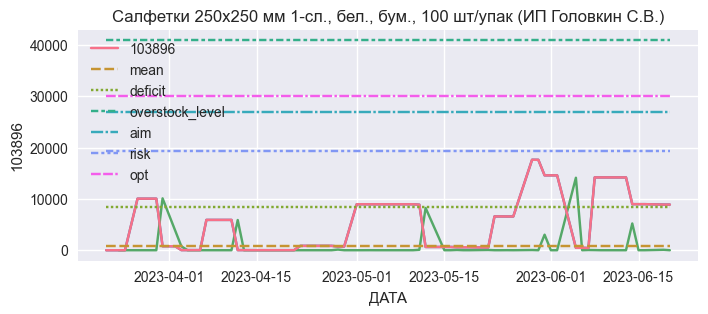

In [99]:
art = 103896

regularity_days = 10
transport_days = 8

if piv_nom[piv_nom['АРТИКУЛ'] == art].shape[0]>0:
    art_name = piv_nom[piv_nom['АРТИКУЛ'] == art]['ТОВАР'].iloc[0]
    curr_stock = piv_nom[piv_nom['АРТИКУЛ'] == art]['curr_stock'].iloc[0]
    deficit_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['deficit_level'].iloc[0]
    risk_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['risk_zone_level'].iloc[0]
    optimum_zone_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['optimum_zone_level'].iloc[0]
    overstock_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['overstock_level'].iloc[0]
    mean_level = piv_nom[piv_nom['АРТИКУЛ'] == art]['sales_mean'].iloc[0]

    stock_on_income = max([curr_stock - mean_level*transport_days,0])
    print('Остаток к приходу: ',stock_on_income)
    print('Середина оптимального остатка: ',optimum_zone_level + (overstock_level-optimum_zone_level)/2)
    print('Зона риска: ',risk_zone_level)

    aim_stock = risk_zone_level + mean_level*regularity_days
    print('Целевой остаток: ',aim_stock)
    order = aim_stock - stock_on_income
    print('Заказ: ',order)

    fig, ax = plt.subplots(1,1, figsize = [8,3])
    sns.lineplot(table[art].T, ax=ax)

    if art in list(table2.columns):
        sns.lineplot(table2[art].T, ax=ax)
    line = pd.DataFrame(table[art].T.copy())


    std_level = (mean_level + 3*table2.describe().T.loc[art]['std'])

    line['mean'] = mean_level
    line['deficit'] = deficit_level
    line['overstock_level'] = piv_nom[piv_nom['АРТИКУЛ']== art]['overstock_level'].iloc[0]
    line['aim'] = aim_stock
    line['risk'] = risk_zone_level
    line['opt'] = optimum_zone_level


    sns.lineplot(line, ax=ax)

    ax.set_title(art_name)

else:
    print('Артикул в регионе без движения и остатков')

In [100]:
#Nomen[Nomen['АРТИКУЛ'] == art]

In [101]:
#piv_nom[piv_nom['cluster_name']=='Ядерные']

In [102]:
#piv_nom[piv_nom['curr_deficit_$']>0].sort_values(by='curr_deficit_$', ascending=False)

In [103]:
#piv_nom[piv_nom['curr_overstok_$']>0].sort_values(by='curr_overstok_$', ascending=False)

In [104]:
#piv_nom[piv_nom['cluster_name']=='Хорошие новинки'].to_excel('Хорошие новинки.xlsx')